In [148]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from shapely.geometry import Polygon, Point, LineString
import pandas as pd
import geopandas as gpd
import folium
from IPython.display import Image
import selenium.webdriver
import shapely.geometry
import osmnx as ox
import pyproj
from geojson.feature import Feature, FeatureCollection
from shapely.geometry import Point, Polygon, LineString
import h3
import json
import branca.colormap as cmp



In [2]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'..\..\..'))
import ExMAS.main
import ExMAS.utils

from ExMAS.utils import inData as inData

In [3]:
params = ExMAS.utils.get_config('ExMAS/data/configs/my_config.json') # load the default 
params.paths.dumps = 'hexes'
params.times.patience = 1200
params.simTime = 4
params.parallel.nThread = 4
params.parallel.nReplications = 20

In [327]:
params.nP = 300 # number of trips
params.simTime = 1 # hours
params.city = 'Amsterdam, Netherlands'
params.shared_discount = 0.45 # relative discount for sharing (i.e. instead of 10EUR single you pay (1-X)*10EUR
params.price = 1.5 # eur/km
params.VoT = 0.0035 # Value-of-time [eur/s]
params.max_degree = 5 # capacity of vehicles (paxes)

In [328]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)

03-12-20 16:24:28-INFO-Initializing pairwise trip shareability between 300 and 300 trips.
03-12-20 16:24:28-INFO-creating combinations
03-12-20 16:24:28-INFO-89700	 nR*(nR-1)
03-12-20 16:24:28-INFO-23211	departure compatibility
03-12-20 16:24:29-INFO-11799	origins shareability
03-12-20 16:24:30-INFO-2668	utility for i
03-12-20 16:24:30-INFO-784	utility for j
03-12-20 16:24:31-INFO-756	LIFO pairs
03-12-20 16:24:31-INFO-Reduction of feasible pairs by 99.16%


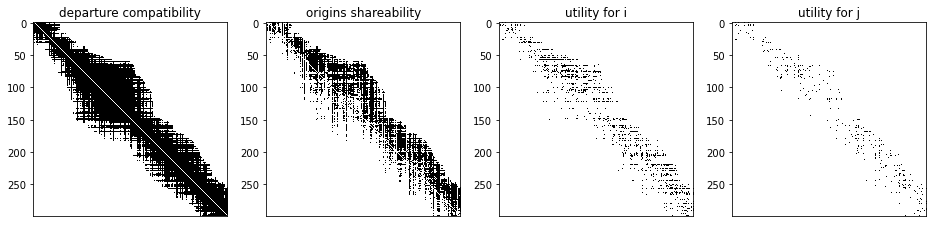

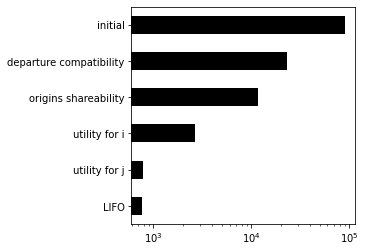

03-12-20 16:24:32-INFO-Degree 2 	Completed
03-12-20 16:24:32-INFO-trips to extend at degree 2 : 1540
03-12-20 16:24:36-INFO-At degree 2 feasible extensions found out of 476 searched
03-12-20 16:24:36-INFO-Degree 3 	Completed
03-12-20 16:24:36-INFO-trips to extend at degree 3 : 476
03-12-20 16:24:37-INFO-At degree 3 feasible extensions found out of 53 searched
03-12-20 16:24:37-INFO-Degree 4 	Completed
03-12-20 16:24:37-INFO-trips to extend at degree 4 : 53
03-12-20 16:24:37-INFO-At degree 4 feasible extensions found out of 4 searched
03-12-20 16:24:37-INFO-Degree 5 	Completed
03-12-20 16:24:37-INFO-Max degree reached 5
03-12-20 16:24:37-INFO-Trips still possible to extend at degree 5 : 4
03-12-20 16:24:40-INFO-Matching 300 trips to 2373 rides in order to min u_veh


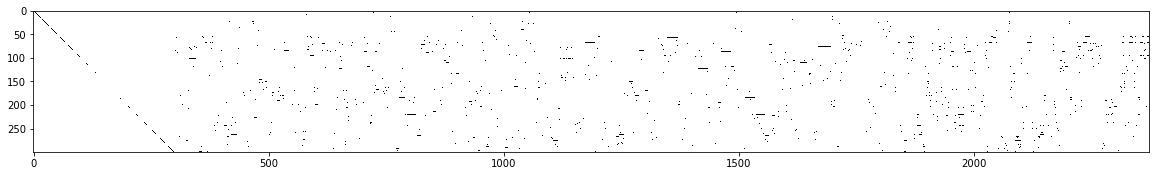

03-12-20 16:24:41-INFO-Problem solution: Optimal. 
Total costs for single trips:        138,356 
reduced by matching to:              116,572
03-12-20 16:24:41-INFO-Calculations  completed
03-12-20 16:24:41-INFO-DotMap(VehHourTrav=115972, VehHourTrav_ns=138356, PassHourTrav=162355, PassHourTrav_ns=138356, PassUtility=1993.748575, PassUtility_ns=2146.081, mean_lambda=0.24436866194023155, revenue_s=114143.70000000001, revenue_ns=207534.0, Fare_Discount=-0.44999999999999996, nR=300, SINGLE=145, PAIRS=40, TRIPLES=21, QUADRIPLES=3, QUINTETS=0, PLUS5=0, shared_ratio=0.5166666666666666, fleet_size_nonshared=45.0, fleet_size_shared=38.0, lambda_shared=0.24436866194023155)


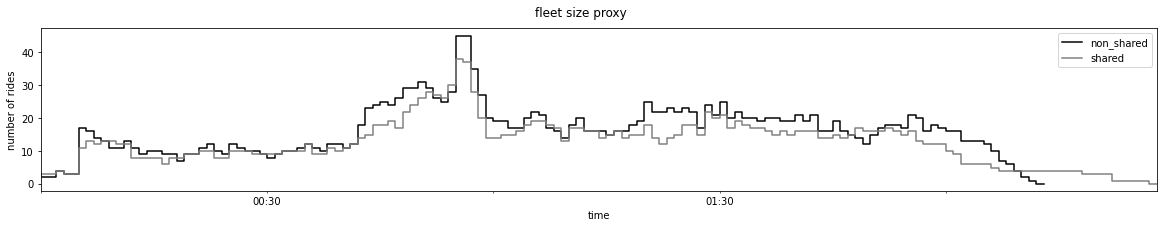

In [329]:
inData = ExMAS.main(inData, params, plot = True)

In [330]:
resop = pd.DataFrame(columns=['lambda_r','u_veh','u_veh_ns', 'index_origin','index_dest','origin','destination'])
resop = resop.fillna(0)

for i in range(len(inData.sblts.rides)):
    a = inData.sblts.rides.lambda_r[i]
    b = inData.sblts.rides.indexes_orig[i]
    c = inData.sblts.requests.origin
    d = inData.sblts.requests.destination
    e = inData.sblts.rides.u_veh[i]
    f = inData.sblts.rides.PassHourTrav_ns[i]
    g = inData.sblts.rides.indexes_dest[i]
    h = inData.sblts.rides.degree[i]
    for j in range(len(b)):
        resop = resop.append({'lambda_r':a,'u_veh':e,'u_veh_ns':f,'index_origin':b[j],'index_dest':g[j],\
                              'origin':c[b[j]],'destination':d[g[j]],'x':c[b[j]],'y':c[b[j]],'degree':h},ignore_index=True)
        
resop['lam_diff'] = resop['lambda_r']-params.shared_discount
resop['u_diff']   = resop['u_veh']-resop['u_veh_ns']
resop['x'] = resop['x'].apply(lambda row: inData.nodes.loc[row].x)
resop['y'] = resop['y'].apply(lambda row: inData.nodes.loc[row].y)
resop['profitable_lam'] = resop['lam_diff'].apply(lambda x: 1 if x>0 else 0)
resop['profitable_u'] = resop['u_diff'].apply(lambda x: 1 if x<0 else 0)

resop = resop[resop['degree']>1]           #filter only sharing rides

In [331]:
resop['u_diff']


300    -212.0
301    -212.0
302    -223.0
303    -223.0
304    -134.0
        ...  
3375    133.0
3376    311.0
3377    311.0
3378    113.0
3379    113.0
Name: u_diff, Length: 3080, dtype: float64

In [332]:
def plot_hex_map(inData,res, APERTURE_SIZE = 8, threshold = 1, col = 'u_diff'):
    res['hex_o_{}'.format(APERTURE_SIZE)] = res.apply(lambda row: h3.geo_to_h3(row.y,row.x,APERTURE_SIZE),axis = 1) 
    trips = res
    
    col_geom = 'hex_o_{}'.format(APERTURE_SIZE)
    hexes = pd.Series(list(set(list(trips[col_geom].unique())+list(trips[col_geom].unique())))).to_frame(col_geom)
    hexes = hexes.set_index(col_geom)
    hexes[col_geom] = hexes.index.copy()
    hexes['nobs'] = trips.groupby(col_geom).size()
    hexes = hexes[hexes['nobs']>threshold]
    hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x[col_geom], geo_json = True)]}, axis = 1)
    aggr = trips.groupby(col_geom)[col]
    hexes['nobs'] = aggr.size()
    hexes[col] = aggr.mean()/60
    hexes[col+'_std'] = aggr.std()
    list_features = []
    for i, row in hexes.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": 9})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
    tile = 'cartodbpositron'
    base_map = folium.Map(location=CENTER, zoom_start=12,tiles=tile, zoomControl =  False)
    bins = [min(res[col]),0.5*min(res[col]),0,0.5*max(res[col]),max(res[col])]
    m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = [col_geom,col],key_on ="feature.id",
            fill_color='YlGnBu', control = False, bins = bins,
            fill_opacity=0.7, line_opacity=0.1,legend_name=col).add_to(base_map)
    m.save('map.html')
    return base_map
    

In [333]:
plot_hex_map(inData, resop, APERTURE_SIZE = 8, col = 'lambda_r')


In [335]:
plot_hex_map(inData, resop, APERTURE_SIZE = 8, col = 'u_diff')

In [317]:
def plot_hex_map1(inData,res, APERTURE_SIZE = 8, threshold = 1, col = 'u_diff'):
    res['hex_o_{}'.format(APERTURE_SIZE)] = res.apply(lambda row: h3.geo_to_h3(row.y,row.x,APERTURE_SIZE),axis = 1) 
    trips = res
    
    col_geom = 'hex_o_{}'.format(APERTURE_SIZE)
    hexes = pd.Series(list(set(list(trips[col_geom].unique())+list(trips[col_geom].unique())))).to_frame(col_geom)
    hexes = hexes.set_index(col_geom)
    hexes[col_geom] = hexes.index.copy()
    hexes['nobs'] = trips.groupby(col_geom).size()
    hexes = hexes[hexes['nobs']>threshold]
    hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x[col_geom], geo_json = True)]}, axis = 1)
    aggr = trips.groupby(col_geom)[col]
    hexes['nobs'] = aggr.size()
    hexes[col] = aggr.mean()/60
    hexes[col+'_std'] = aggr.std()
    list_features = []
    for i, row in hexes.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": 9})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
    tile = 'cartodbpositron'
    base_map = folium.Map(location=CENTER, zoom_start=13,tiles=tile, zoomControl =  False)
    #bins = [min(res[col]),0,max(res[col])]
    linear = cmp.LinearColormap(['green','yellow','red'], vmin=min(res[col]), vmax=max(res[col]))
    m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = [col_geom,col],key_on ="feature.id",\
                          fillColor= 'RdPu',fill_opacity=0.7, line_opacity=0.1,legend_name=col,\
                          control = False).add_to(base_map)
    saveit = m.save('map.html')
    return base_map, saveit